In [1]:
import os
from pyrsgis import raster
from sklearn import cluster
from osgeo import gdal
import geopandas as gdp
import pandas as pd
import numpy as np
import rasterio as rio
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import matplotlib.pyplot as plt
from glob import glob
from rasterio.plot import show
import pandas as pd
import cv2

Warning! matplotlib_scalebar library not found.


**Group Members:** <br><br> Luis Garcia <br> Caleb Roudy <br> Rowan Beswick

**The 2019 to 2020 Australian bushfire season, also known as Black summer, was one of the worst natural disasters in modern history. Not only causing havic within some on the wider ecosystem in central- southern Australia, but also affecting human society. By the end of it all, more than 9,000 buildings were vanquished, along with 34 unfortunate lives lost.These damages can be assessed from above with the many commericial domestic and international satelittes and platforms. One of the more prominent platforms from above is Landsat 8, which has been around monitoring most portions of the globe. The images from the satelitte are utilized to monitor and detect surface processes such as wildfire, ice melt, deforestation, as well as others. 
# Methods

Data used entails (band 1 — band 7) of Landsat 8/OLI Sydney fire as features  and try to predict the binary fire/nonfire class. These 2 images will be used for training and testing. Finally, another multispectral Landsat 8 data acquired in the  the outside of Newcastle( rural town of Murrurundi)  will be used for new predictions. To further prove the effiency o this method, a California fire image will also. Lastly, a Desicion Tree method will also be implemented on the California Fire.

**Portions of the electromagnetic spectrum that Landsat 8/OLI covers**
![image](https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/dmidS2LS7Comparison.png)
This is a graph showing the different ranges and disributions of the electromagnetic spectrum at which each sensors covers. Most areas at which they cover were designed to capture solar radiation signal from the so called "Atmosphereic Window" <br><BR>
<i> Source of graphic </i>: https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/dmidS2LS7Comparison.png 

**Graphic design of the neural network workflow for wildfire detection**
![image](https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/dmidS2LS7Comparison.png)
This is a graph showing the different ranges and disributions of the electromagnetic spectrum at which each sensors covers. Most areas at which they cover were designed to capture solar radiation signal from the so called "Atmosphereic Window" <br><BR>
<i> Source </i>: https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/dmidS2LS7Comparison.png 

In [2]:
# Landsat 8/OLI image of Outside of Sydney
southerAus = 'LC08_L1TP_090083_20191215_20191226_01_T1/LC08_20191215_1226_LayersStacked_ALL.tif' 
# 'LC08_L1TP_090083_20191215_20191226_01_T1/LC08_20191215_1226_LayersStacked_ALL.tif'

# Binary Classification of fire non fire ground truth of Sydney (produced from K-means)
fire_Binary = 'LC08_L1TP_090083_20191215_20191226_01_T1_NEW/min_distance_fire_nonfire.tif' 

# Outside of Newcastle in the rural town of Murrurundi 
eastAus = 'LC08_L1TP_090082_20191231_20200111_01_T1/LC08_20191231_20200111_01_T1_Stacked.tif' 

#LC08_L1TP_091086_20191222_20200110_01_T1 (Victoria, Australia- outside of the town of Bumberrah)

# Read the rasters as array
ds7, featuresSouthAus = raster.read(southerAus, bands='all')
ds6, labelsAus = raster.read(fire_Binary, bands=1)
ds5, featuresEastAus = raster.read(eastAus, bands='all')

In [3]:
print("Fire b7 image shape: ", featuresSouthAus.shape)
print("Fire b6 image shape: ", labelsAus.shape)
print("Fire b5 image shape: ", featuresEastAus.shape)

Fire b7 image shape:  (7, 7691, 7621)
Fire b6 image shape:  (7691, 7621)
Fire b5 image shape:  (7, 7701, 7641)


In [4]:
from pyrsgis.convert import changeDimension

featuresSouthAus = changeDimension(featuresSouthAus)
labelsAus  = changeDimension(labelsAus)
featuresEastAus = changeDimension(featuresEastAus)
nBands = featuresSouthAus.shape[1]
labelsAus= (labelsAus == 1).astype(int)

print("Souther Aus multispectral image shape: ", featuresSouthAus.shape)
print("Southern Aus Fire/nonFire binary shape: ", labelsAus.shape)
print("Victoria multispectral image shape: ", featuresEastAus.shape)

Souther Aus multispectral image shape:  (58613111, 7)
Southern Aus Fire/nonFire binary shape:  (58613111,)
Victoria multispectral image shape:  (58843341, 7)


In [5]:
from sklearn.model_selection import train_test_split

                              #X (Indepent Varibles/Data)  #y(Dependent/Labels (Fire/NonFire))
xTrain, xTest, yTrain, yTest = train_test_split(featuresSouthAus, labelsAus, test_size=0.4, random_state=42)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

(35167866, 7)
(35167866,)
(23445245, 7)
(23445245,)


In [6]:
# Normalise the data
xTrain = xTrain / 255.0
xTest = xTest / 255.0
featuresEastAus =  featuresEastAus / 255.0


# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))
featuresEastAus = featuresEastAus.reshape((featuresEastAus.shape[0], 1, featuresEastAus.shape[1]))

# Print the shape of reshaped data
print(xTrain.shape, xTest.shape, featuresEastAus.shape)



(35167866, 1, 7) (23445245, 1, 7) (58843341, 1, 7)


In [7]:
from tensorflow import keras

# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(14, activation='relu'), 
    keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model.fit(xTrain, yTrain, epochs=2)

Train on 35167866 samples
Epoch 1/2
35167866/35167866 [==============================] - 990s 28us/sample - loss: 0.0027 - accuracy: 0.9999
Epoch 2/2
35167866/35167866 [==============================] - 984s 28us/sample - loss: 1.1570e-04 - accuracy: 1.0000


In [8]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Predict for test data 
yTestPredicted = model.predict(xTest)
yTestPredicted = yTestPredicted[:,1]

# Calculate and display the error metrics
yTestPredicted = (yTestPredicted>0.5).astype(int)
cMatrix = confusion_matrix(yTest, yTestPredicted)
pScore = precision_score(yTest, yTestPredicted)
rScore = recall_score(yTest, yTestPredicted)

print("Confusion matrix: for 14 nodes\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))

Confusion matrix: for 14 nodes
 [[23439887      435]
 [     103     4820]]

P-Score: 0.917, R-Score: 0.979


In [9]:
predicted = model.predict(featuresEastAus)
predicted = predicted[:,1]
#Export raster
prediction = np.reshape(predicted, (ds5.RasterYSize, ds5.RasterXSize))
outFile = 'Eastern Australia Fire Prediction.tif'
raster.export(prediction, ds5, filename=outFile, dtype='float')

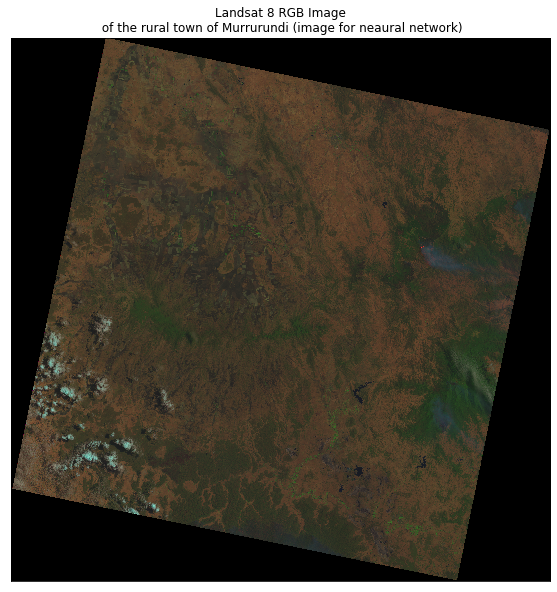

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [12]:
# Image of the fire in Newcastle( rural town of Murrurundi)
landsat_path = glob("LC08_L1TP_090082_20191231_20200111_01_T1/LC08_L1TP_090082_20191231_20200111_01_T1_B*.TIF")
landsat_path.sort()
array_stack, meta_data = es.stack(landsat_path)


rgb = ep.plot_rgb(array_stack,
            rgb=[5, 4, 2],
            title="Landsat 8 RGB Image\n of the rural town of Murrurundi (image for neaural network)")
plt.figure(figsize=(4,4))

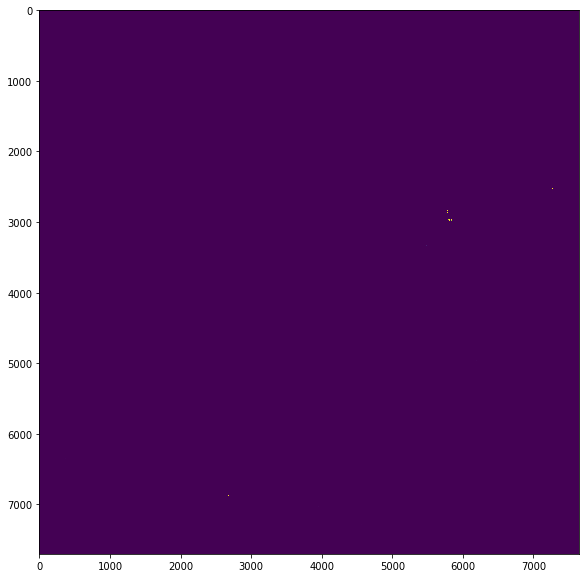

In [13]:
# Read File Raster Data as Array using Gdal
img_file = "Eastern Australia Fire Prediction.tif"
gtif = gdal.Open(img_file)
georaster = gtif.ReadAsArray()

 # Plot image using matplotlib
plt.figure(figsize=(10,10))
plt.imshow(georaster)

In [ ]:
rgb[targ_pred] = 1
plt.figure(figsize=(20,20))
plt.imshow(imgcolor)
plt.show()